/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

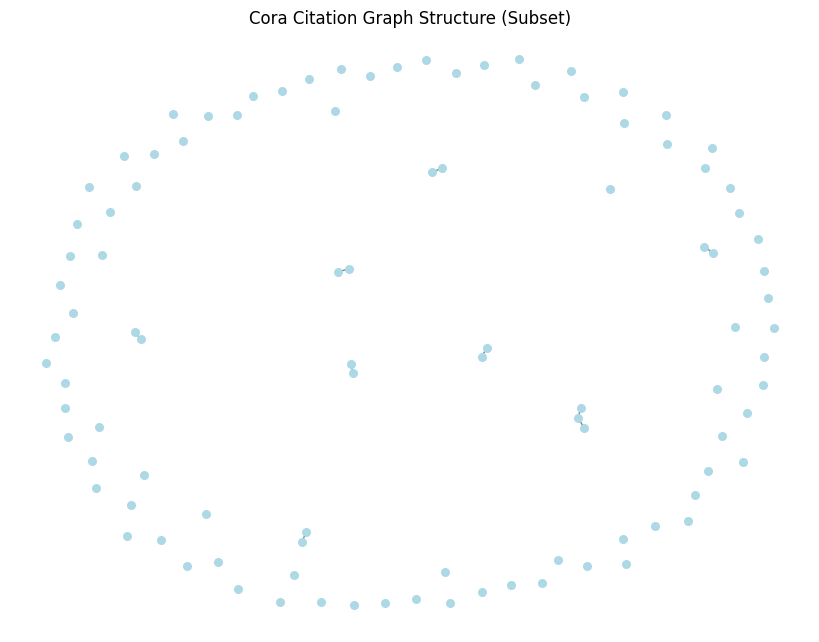

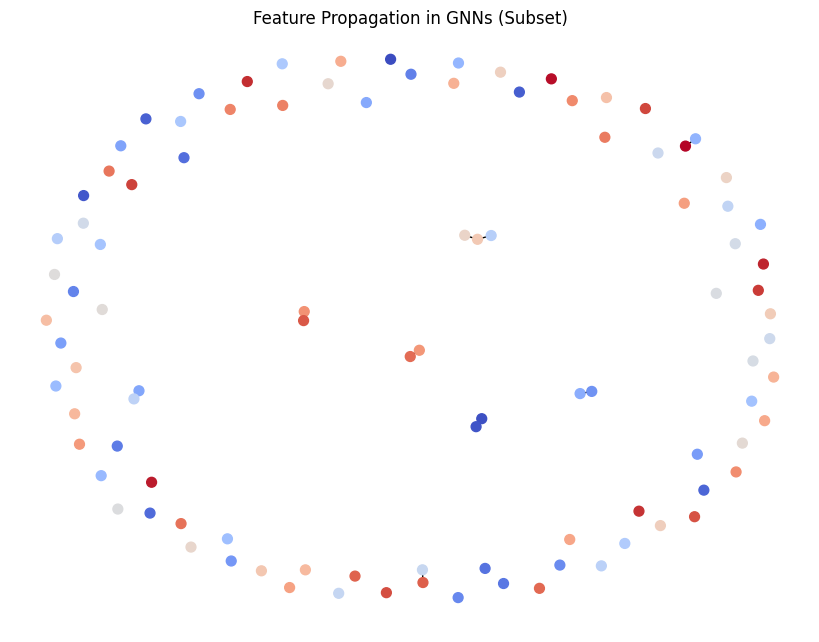

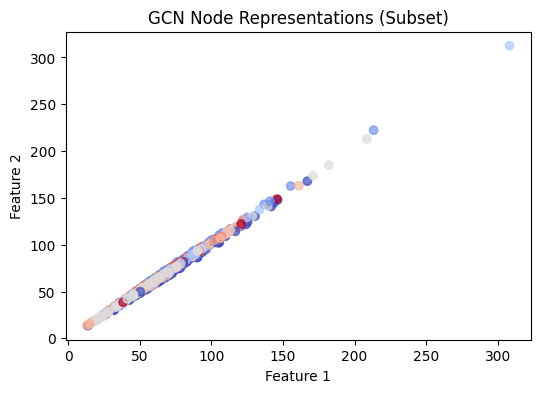

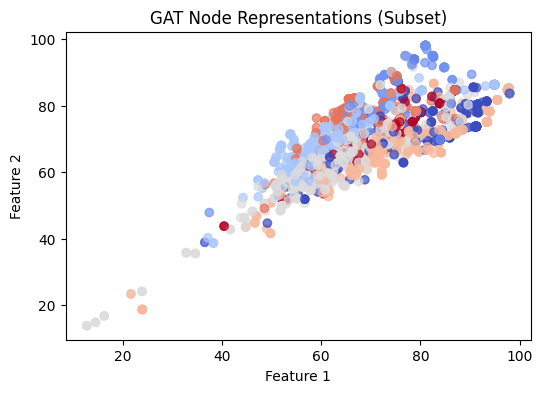

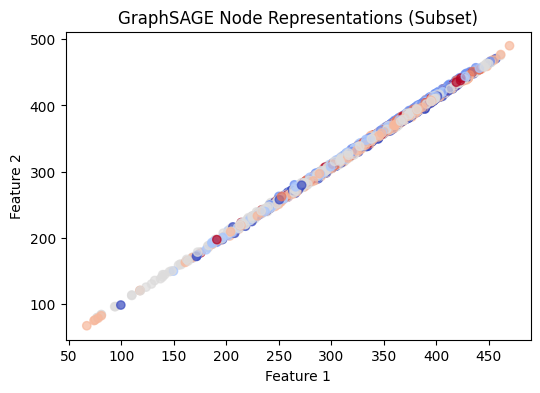

In [3]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
import torch.nn.functional as F

# Load a smaller subset of the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Convert PyG graph to NetworkX for visualization (limiting nodes for clarity)
G = to_networkx(data, to_undirected=True)
small_G = G.subgraph(list(G.nodes)[:100])  # Taking a small subset for visualization

# 1. **Graph Structure Visualization (Smaller Subset)**
plt.figure(figsize=(8, 6))
nx.draw(small_G, with_labels=False, node_color='lightblue', edge_color='gray', node_size=30)
plt.title("Cora Citation Graph Structure (Subset)")
plt.show()

# 2. **Feature Propagation Visualization**
# Visualizing information propagation through message passing in GNNs
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(small_G, seed=42)
nx.draw(small_G, pos, with_labels=False, node_color=list(range(len(small_G.nodes))), cmap='coolwarm', node_size=50)
plt.title("Feature Propagation in GNNs (Subset)")
plt.show()

# Define simple GNN models
class GCN(torch.nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_feats, hidden_feats)
        self.conv2 = GCNConv(hidden_feats, out_feats)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

class GAT(torch.nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_feats, hidden_feats, heads=2, concat=False)
        self.conv2 = GATConv(hidden_feats, out_feats, heads=2, concat=False)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_feats)
        self.conv2 = SAGEConv(hidden_feats, out_feats)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Train models and generate outputs
models = {"GCN": GCN(dataset.num_node_features, 16, dataset.num_classes),
          "GAT": GAT(dataset.num_node_features, 16, dataset.num_classes),
          "GraphSAGE": GraphSAGE(dataset.num_node_features, 16, dataset.num_classes)}

def train_model(model, data, epochs=50, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
    return out

outputs = {}
for name, model in models.items():
    outputs[name] = train_model(model, data)

# 3. **Node Representations for GNN Models**
for name, output in outputs.items():
    plt.figure(figsize=(6, 4))
    plt.scatter(output[:, 0].detach().numpy(), output[:, 1].detach().numpy(), c=data.y.numpy(), cmap='coolwarm', alpha=0.7)
    plt.title(f"{name} Node Representations (Subset)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


In [2]:
pip install torch-geometric torch-sparse torch-scatter torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.9/750.9 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.2 MB/s eta 0:00:00
